# VARIABLES INSTRUMENTALES

Cette application s'inspire étroitement du chapitre : 

https://www.econometrics-with-r.org/12-ivr.html qui est lui même un suppélment R au manuel de Stock et Watson (cf. bibliographie du cours). 

On cherche à savoir quel est l'impact de l'augmentation du prix du paquet de cigarette sur la consommation. 

Pour cela on utilise la base de données CigarettesSW du package AER, et on sélectionne un sous échantillon que l'on nomme d : 

In [1]:
install.packages("AER")
library(AER)
d <- data("CigarettesSW",package="AER")
d <- subset(CigarettesSW, year == "1995")
class(d)
head(d)

package 'AER' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\lmartinoty\AppData\Local\Temp\RtmpCkXKg6\downloaded_packages


Loading required package: car
Loading required package: carData
Loading required package: lmtest
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: survival


[1] "data.frame"

,state,year,cpi,population,packs,income,tax,price,taxs
49,AL,1995,1.524,4262731,101.08543,83903280,40.50000,158.3713,41.90467
50,AR,1995,1.524,2480121,111.04297,45995496,55.50000,175.5425,63.85917
51,AZ,1995,1.524,4306908,71.95417,88870496,65.33333,198.6075,74.79082
52,CA,1995,1.524,31493524,56.85931,771470144,61.00000,210.5047,74.77133
53,CO,1995,1.524,3738061,82.58292,92946544,44.00000,167.3500,44.00000
54,CT,1995,1.524,3265293,79.47219,104315120,74.00000,218.2805,86.35550


Pour le codebook, on entre ?CigarettesSW :

In [2]:
?CigarettesSW

# 1. Régression simple

Le plus simple est de commencer par estimer un modèle de base. On estime un modèle de régression de la demande $packs$ sur le prix $price$. 

On souhaite estimer **l'élasticité** de la demande au prix. Effectuer les transformations de données qui s'imposent.

In [3]:
d$lprice<-log(d$price)
d$lpacks<-log(d$packs)
head(d)

,state,year,cpi,population,packs,income,tax,price,taxs,lprice,lpacks
49,AL,1995,1.524,4262731,101.08543,83903280,40.50000,158.3713,41.90467,5.064943,4.615966
50,AR,1995,1.524,2480121,111.04297,45995496,55.50000,175.5425,63.85917,5.167881,4.709917
51,AZ,1995,1.524,4306908,71.95417,88870496,65.33333,198.6075,74.79082,5.291331,4.276029
52,CA,1995,1.524,31493524,56.85931,771470144,61.00000,210.5047,74.77133,5.349508,4.040580
53,CO,1995,1.524,3738061,82.58292,92946544,44.00000,167.3500,44.00000,5.120087,4.413803
54,CT,1995,1.524,3265293,79.47219,104315120,74.00000,218.2805,86.35550,5.385781,4.375407


Estimer le modèle. Interpréter.

In [4]:
simple<-lm(d$lpacks~d$lprice)
summary(simple)


Call:
lm(formula = d$lpacks ~ d$lprice)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.64676 -0.09030  0.01787  0.11245  0.40779 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  10.8500     1.1265   9.632 1.32e-12 ***
d$lprice     -1.2131     0.2164  -5.604 1.13e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1896 on 46 degrees of freedom
Multiple R-squared:  0.4058,	Adjusted R-squared:  0.3928 
F-statistic: 31.41 on 1 and 46 DF,  p-value: 1.13e-06


<font color=green> Une hausse du prix de 1% est associée à une baisse de la demande de 1.21% Attention, pas de causalité à ce stade.</font>

Jusque là, nous avons estimé nos modèles linéaires par MCO sans ajsuter nos écart-types pour l'hétéroscédasticité. Sur R il est possible de calculer des écart-type robustes de White en post-estimation par la ligne de commande : **coeftest(model, vcov = vcovHC, type = "HC1")**.

Recaclulez les écart-types associés aux coefficients du modèle que nous venons d'estimer. Sont-ils plus ou moins élevés ? 

In [5]:
coeftest(simple, vcov = vcovHC, type = "HC1")


t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 10.85003    1.01678 10.6710 4.955e-14 ***
d$lprice    -1.21306    0.19459 -6.2339 1.290e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


<font color=green> Ils sont moins élevés, ce qui veut dire que nous rejeterons H0 de nullité du coeff plus facilement. C'est loin d'être toujours le cas, le plus souvent ils sont plus élevés. </font>

Pourquoi le coefficient est-il biaisé selon toute probabilité ?

<font color=green> La relation entre la demande d'un bien et son prix est un problème classique en économie. 

En théorie, la question est simple : si le prix augmente, la demande baisse. 
- Cependant, en retour, le prix est également affecté par la demande (causalité inverse). 
- De plus, il est également affecté par l'offre, indissociable de la demande (variable omise). Ainsi la relation entre demande et prix ne dit que peu de choses sur l'effet causal du prix sur la demande. </font>

# 2. Instrumentation : modèle simple

La relation entre la demande d'un bien et son prix est un problème classique en économie. 

En théorie, la question est simple : si le prix augmente, la demande baisse. 
- Cependant, en retour, le prix est également affecté par la demande (causalité inverse). 
- De plus, il est également affecté par l'offre, indissociable de la demande (variable omise). Ainsi la relation entre demande et prix ne dit que peu de choses sur l'effet causal du prix sur la demande. 

Comment limiter le biais d'estimation ?

C'est une question importante en économie de la santé. En effet, imaginons que l'on veuille limiter la mortalité liée au tabac, autrement dit faire baisser la consommation de cigarettes. Certains vont proposer une augmentation du prix du paquet pour faire diminuer la demande. Il est important de connaître précisément comment la demande va répondre.

Or si je régresse la demande sur le prix j'obtiendrai une corrélation entre les deux. 

Si l'on veut connaître l'effet causal du prix sur la demande, il faut donc trouver un facteur : 
- qui affecte le prix mais qui n'est pas lié à la demande (enfin pas autrement qu'à travers le prix), 
- qui affecte le prix mais pas l'offre. 

**On réfléchit à un instrument pour le prix, et on propose la taxe à la consommation** (*sales tax* en anglais, TVA en français).

### 2.1 Instrument : création et discussion 

On crée la variable *TVA*  à partir des variables disponibles. 

In [6]:
d$TVA<-d$taxs-d$tax

Vérifiez graphiquement que cette taxe varie bien entre les différents Etats américains.

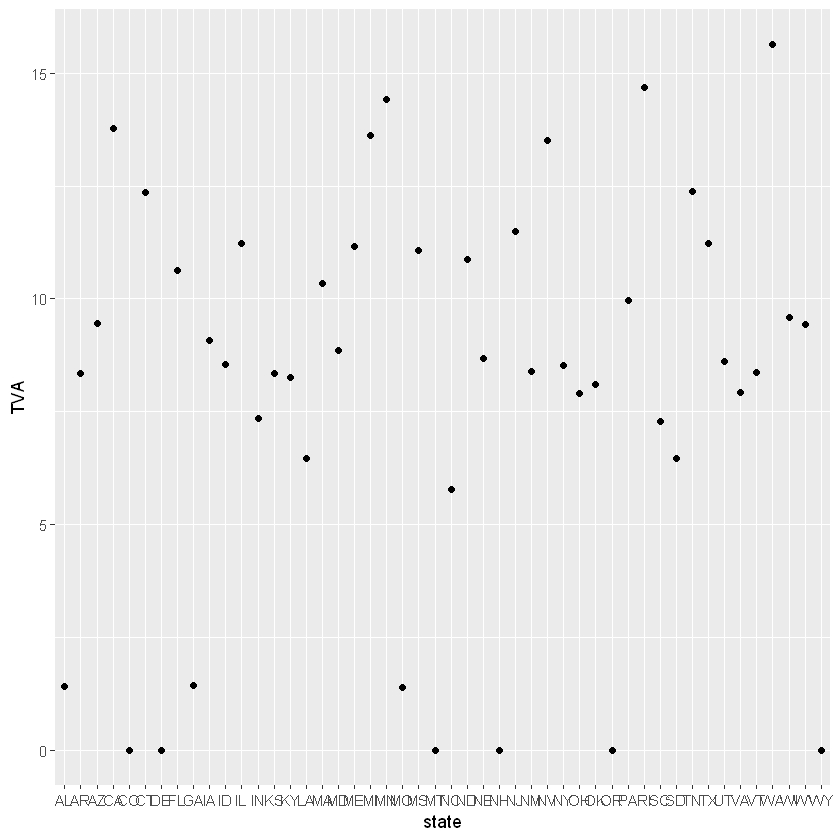

In [7]:
library(ggplot2)
ggplot(d, aes(x=state,y=TVA)) + geom_point()

Expliquez pourquoi cette taxe peut être un bon instrument pour le prix du paquet.

<font color=green> 
- Pertinence : il est évident que la taxe a un impact sur le prix puisque la TVA est généralement retransmise par les industriels. 
- Exogénéité : on voit mal comment la TVA affecterait la demande autrement qu'à travers le prix du paquet.
</font>

### 2.2 Intuition : Estimation par étape

Estimer la première étape (avec erreurs-types robustes). Quel signe s'attend-on à trouver ? Que penser du $R^2$ ?

In [8]:
ivsimple_FS <- lm(lprice ~ TVA, data = d)
coeftest(ivsimple_FS, vcov = vcovHC, type = "HC1")


t test of coefficients:

             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) 5.0378847  0.0289177 174.2147 < 2.2e-16 ***
TVA         0.0201633  0.0031729   6.3549 8.489e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


<font color=green> On remarque que la relation est bien positive et significative : plus les taxes sont élevées, plus les prix le sont. 
La taxe est donc bien répercutée aux consommateurs. 

On remarque que l'instrument peut être pertinent puisque le R2 est élevé : la variation des taxes peut rendre compte de 47% de la variation des prix. </font>

Prédire le prix des cigarettes que l'on nommera *instrumented_lprice*.

In [9]:
d$instrumented_lprice <- ivsimple_FS$fitted.values

Estimer la seconde étape (avec erreurs-types robustes) et conclure. 

In [10]:
ivsimple_SS <- lm(lpacks ~ instrumented_lprice, data = d)
coeftest(ivsimple_SS, vcov = vcovHC, type = "HC1")


t test of coefficients:

                    Estimate Std. Error t value  Pr(>|t|)    
(Intercept)          10.1764     1.7377  5.8563 4.753e-07 ***
instrumented_lprice  -1.0836     0.3337 -3.2472  0.002178 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


<font color=green> Quand le prix augmente de 1%, la demande baisse de 1,08%. </font>

Retrouver ce résultat en estimant la forme réduite. *Indice : dans le modèle simple, l'estimateur par variable instrumentale est le rapport de la forme réduite sur la première étape.*

In [11]:
ivsimple_RF <- lm(lpacks ~ TVA, data = d)
RF_FS <- coef(ivsimple_RF)[2]/coef(ivsimple_FS)[2]
RF_FS

TVA 
-1.083587

### 2.3 Estimation jointe des deux étapes par *ivreg*
Il existe une commande sur R intégrant les deux étapes : **ivreg()** du package **AER**. En effet les deux étapes doivent être estimées de manière jointe car autrement, le fait que le prix soit une valeur prédite par un modèle est ignoré dans l'estimation des écarts-types. On remplace **lm()** par **ivreg(y~x|z,data=...)**. On estime le modèle directement par l'estimateur des variables instrumentales (et avec erreurs-types robustes).

In [12]:
ivsimple<-ivreg(lpacks ~ lprice | TVA , data=d)
coeftest(ivsimple, vcov = vcovHC, type = "HC1")


t test of coefficients:

            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.17643    1.66268  6.1205 1.91e-07 ***
lprice      -1.08359    0.31892 -3.3977 0.001411 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


# 3. Estimateur des variables instrumentales avec plusieurs variables

### 3.1 Estimation

On estime le modèle complet, c'est-à-dire le modèle comprenant également des variables de contrôle exogènes. 

*Indice : la structure est ivreg(y~x+w|z+w) avec x variables endogènes, w variables exogènes, z instruments.*

In [13]:
ivmultiple <- ivreg(lpacks ~ lprice + log(income) | log(income) + 
                    TVA, data = d)
coeftest(ivmultiple, vcov = vcovHC, type = "HC1")


t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 10.153224   1.606881  6.3186 1.049e-07 ***
lprice      -1.003058   0.321948 -3.1156  0.003192 ** 
log(income) -0.021801   0.027334 -0.7976  0.429304    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### 3.2 Instrument faible : test de la pertinence

Quel est le problème si notre instrument est faible ?

<font color=green> 
Biais de variable omise : même un petit biais d’estimation dans la
forme réduite sera amplifié lors de la réévaluation par la première
étape.

</font>

Pour savoir si on a un problème d'instrument faible que calcule-t-on? Quelle est la règle de décision? 

<font color=green> 
    
Statistique de Fischer de la première étape (égalité du coeff du modèle à 0). 

Régle de décision à la louche : si le Fstat de la première étape est
inférieur à 10, alors les instruments sont faibles.

</font>

Réaliser l'estimation et le test ( Indice : le test se réalise avec **linearHypothesis(model,"coeff=0", vcov=vcovHC, type="HC1")**. Conclure.

In [14]:
mod_relevance <- lm(lprice ~ TVA + log(income), data=d)

In [15]:
linearHypothesis(mod_relevance1, 
                 "TVA = 0", 
                 vcov = vcovHC, type = "HC1")

ERROR: Error in linearHypothesis(mod_relevance1, "TVA = 0", vcov = vcovHC, type = "HC1"): objet 'mod_relevance1' introuvable


Plutôt que se fatiguer, on peut obtenir le test directement avec l'option de **summary()**: **diagnostics=TRUE**. Vérifier le résultat précédent.  

In [ ]:
summary(ivmultiple, diagnostics = TRUE, vcov = vcovHC, type = "HC1")

# 4. Estimateur des variables instrumentales avec plusieurs variables et plusieurs intruments

### 4.1 Estimation

On a un second instrument : les taxes spécifiques sur les cigarettes : *tax*. Estimer le modèle multiple avec deux instruments par l'estimateur des variables instrumentales, et comparer avec le résultat de 3.1. 

In [ ]:
ivmultiple2 <- ivreg(lpacks ~ lprice + log(income) | 
                    log(income) + TVA + tax, data = d)
coeftest(ivmultiple2, vcov = vcovHC, type = "HC1")

<font color=green> Coefficient plus élevé (Elasticité de 1.09 contre 1.00). Ecart-type plus faible (0.19 contre 0.32) donc davantage de précision avec ce modèle. On garde ce modèle **SI et seulement si les deux instruments sont valides bien sûr**. </font>

### 4.2 Test de suridentification : test de l'exogénéité



En quoi consiste le test de suridentification ?

<font color=green> One crucial property of instruments is that they ought to be uncorrelated to the regression error terms $u$. Instrument exogeneity is set as the null hypothesis of this following test with the alternative hypothesis being that the instruments are endogenous. This test can only be applied if you have more instruments than endogenous variables. It is therefore sometimes also called the test for overidentifying restrictions.

The test is rather simple to implement. Take the residuals from the 2SLS regression in 4.1 and use them as the dependent variable in a new regression in which you regress them on all exogenous explanatory variables and all instruments.

If the instruments are valid (null hypothesis), they should be uncorrelated to these residuals and hence we apply the following $\chi^2$ test. We use the $R^2$ of this regression and calculate $n*R^2$


</font>

Calculer la statistique de test. 

In [ ]:
sargan_reg <- lm(residuals(ivmultiple2) ~ log(income) + TVA + tax, data=d)
sargan_reg_sum <- summary(sargan_reg)
Sargan_test <- sargan_reg_sum$r.squared*nrow(d)
Sargan_test

Calculer la p-value associée (sous H0, la statistique suit une loi de Chi2 à (m-k) degrés de liberté).

In [ ]:
#rappel : une pvalue est l'aire à la droite de la valeur calculée (sous H0, proba que la stat de test soit au moins égale à ce chiffre, ou supérieure)
#degrés de liberté : m-k=nb d'instruments-nb de variabels instrumentées = 1 ici
#pchisq() donne l'aire à GAUCHE du chi2 calculé : Sargan_test
pchisq(Sargan_test,1)
#nous souhaitons la valeur à droite du chi2 calculé : 
1-pchisq(Sargan_test,1)  

Conclure. 

<font color=green> La pvalue est largement supérieure à 0.10 : on ne rejette pas H0. Les deux instruments sont exogènes (ou alors endogènes de la même manière...). </font>

Vérifier que l'option **diagnostics** de **summary()** donne le même nombre (dans le tableau, c'est le 'Sargan test'). 

In [ ]:
summary(ivmultiple2, diagnostics=TRUE)

# 5. Tableau de résultat : Pour produire un beau tableau

### 5.1 Installer le package stargazer

In [ ]:
install.packages("stargazer")

### 5.2 Charger la library stargazer

In [ ]:
library(stargazer)

### 5.3 Faire tourner ce code 

In [ ]:
# écarts-type robustes
rob_se <- list(sqrt(diag(vcovHC(ivsimple,    type = "HC1"))),
               sqrt(diag(vcovHC(ivmultiple,  type = "HC1"))),
               sqrt(diag(vcovHC(ivmultiple2, type = "HC1"))))

# tableau
stargazer(ivsimple, ivmultiple,ivmultiple2,
  header = FALSE, 
  type = "text",
  omit.table.layout = "n",
  digits = 3, 
  column.labels = c("Modèle simple", "Modèle multiple", "Modèle multiple <br> deux IV"),
  dep.var.labels.include = FALSE,
  dep.var.caption = "Dependent Variable: 1985-1995 Difference in Log per Pack Price",
  se = rob_se)

### Remarque : On peut créer le tableau avec **type = "html"** (que l'on peut ouvrir avec word ensuite)

<table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3">Dependent Variable: 1985-1995 Difference in Log per Pack Price</td></tr>
<tr><td></td><td colspan="3" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td>Modèle simple</td><td>Modèle multiple</td><td>Modèle multiple <br> deux IV</td></tr>
<tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td></tr>
<tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">lprice</td><td>-1.084<sup>***</sup></td><td>-1.003<sup>***</sup></td><td>-1.093<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.319)</td><td>(0.322)</td><td>(0.199)</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">log(income)</td><td></td><td>-0.022</td><td>-0.019</td></tr>
<tr><td style="text-align:left"></td><td></td><td>(0.027)</td><td>(0.027)</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td style="text-align:left">Constant</td><td>10.176<sup>***</sup></td><td>10.153<sup>***</sup></td><td>10.562<sup>***</sup></td></tr>
<tr><td style="text-align:left"></td><td>(1.663)</td><td>(1.607)</td><td>(1.044)</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></td></tr>
<tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Observations</td><td>48</td><td>48</td><td>48</td></tr>
<tr><td style="text-align:left">R<sup>2</sup></td><td>0.401</td><td>0.402</td><td>0.408</td></tr>
<tr><td style="text-align:left">Adjusted R<sup>2</sup></td><td>0.388</td><td>0.376</td><td>0.382</td></tr>
<tr><td style="text-align:left">Residual Std. Error</td><td>0.190 (df = 46)</td><td>0.192 (df = 45)</td><td>0.191 (df = 45)</td></tr>
<tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr></table>

On peut aussi avoir un format de tableau pour LaTex en remplaçant **type = "text"** par **type = "latex"**.